*This notebook was created by Sergey Tomin (sergey.tomin@xfel.eu). Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). June 2019.*

## Tutorial N9. Synchrotron radiation module.

Synchrotron radiation module is also included to the OCELOT multiphysics simulation toolkit .

The OCELOT SR module is capable of calculating spectrum and spatial distribution of spontaneous radiation from a single electron in a magnetic field defined by file data (field on an insertion device axis or 2D map in the plane of the electron motion) or using standard elements as Undulator with arbitrary defined period, length and K.

### Contents
1. [Ideal magnetic field](#ideal)
    2. [Spatial distribution](#spatial)
    3. [Spectrum](#spectrum)
2. [Magnetic Field map on the undulator axis](#phys_proc) 
3. [Coherent radiation from ParticleArray](#simulation)

<a id='ideal'></a>
## Ideal magnetic field

To estimate SR from undulator you can use ideal sinus like magnetic field ($B_y(x, y, z) = B_0 \sin(\lambda_u z)$) with $B_x(x, y, z) = B_z(x, y, z) = 0$. 

In that case, we can use **Undulator** element with standard parameters like $K$, period length, number of periods. 


In [1]:
# To activate interactive matplolib in notebook
%matplotlib notebook

In [2]:
import sys
sys.path.append("/Users/tomins/ownCloud/DESY/repository/ocelot")
# import main functions from Synchrotron Radation (SR) module 
from ocelot.rad import *
# import OCELOT main functions 
from ocelot import *
# import OCELOT plotting functions 
from ocelot.gui import *

initializing ocelot...


As usual we start from creating elements and lattice. 

At the moment SR module recognize only **Undulator** element. Even if you want to calculate radiation from dipole magnet. 

In [3]:
und = Undulator(Kx=0.43, nperiods=500, lperiod=0.007, eid="und")

lat = MagneticLattice((und))

To calculate radiation need two additional objects
* ```Beam()``` 
to provide the electron beam energy and beam current. 
<div class="alert alert-block alert-warning">
<b>Note:</b> The earlier version of SR solver could calculate emittance and energy spread effect. In current version, we focus on single electron radiation. Although, these effects can be added to subsequent releases.  </div>

* ```Screen()```  class to store radiation field and to provide information about screen parameters where radiation will be observed.

<a id='spatial'></a>
### Spatial distribution

To calculate spatial distribution we need to define screen size(s) and number of points in each planes.
We start with simplest 1D case. 

In [5]:
beam = Beam()
beam.E = 2.5            # beam energy in [GeV]
beam.I = 0.1            # beam current in [A]


screen = Screen()
screen.z = 100.0      # distance from the begining of lattice to the screen 
screen.size_x = 0.002 # half of screen size in [m] in horizontal plane
screen.size_y = 0.    # half of screen size in [m]
screen.nx = 100       # number of points in horizontal plane 
screen.ny = 1         # number of points in horizontal plane 


screen.start_energy = 7761.2 # [eV], starting photon energy
screen.end_energy = 7900     # [eV], ending photon energy
screen.num_energy = 1        # number of energy points[eV]

#### Calculate SR 
to calculate SR from one electron there is function:

```screen = calculate_radiation(lat, screen, beam)```

* ```lat```: MagneticLattice should include element Undulator
* ```screen```: Screen class
* ```beam```: Beam class, the radiation is calculated from one electron

Optional parameters:

* ```energy_loss```: False, if True includes energy loss after each period
* ```quantum_diff```: False, if True introduces random energy kick
* ```accuracy```: 1,  scale for trajectory points number 
* ```end_poles```: False, if True includes end poles with 1/4, -3/4, 1, ... 

In [7]:
screen = calculate_radiation(lat, screen, beam)

Electric field is stored in 1D arrays

* ```screen.arReEx```: array, Real part of horizontal component of the electric field
* ```screen.arImEx```: array, Imaginary part of horizontal component of the electric field
* ```screen.arReEy```: array, Real part of the vertical component of the electric field
* ```screen.arImEy```: array, Imaginary part of the vertical component of the electric field
* ```screen.arPhase```: array, phase between Re and Im components

Also, **Screen** has coordinates where radiation was calculated 

* ```screen.Xph```, 1D array with coordinates in horizontal plane 
* ```screen.Yph```, 1D array with coordinates in vertical plane
* ```screen.Eph```, 1D array with coordinates in energetic plane

Photon flux is calculated from the electric field and stored in 1D arrays:

* ```screen.Sigma```: horizontal polarization component in $\left[\frac{ph}{sec \cdot mm^2 10^{-3}BW}\right]$
* ```screen.Pi```: vertical polarization component in $\left[\frac{ph}{sec \cdot mm^2 10^{-3}BW}\right]$
* ```screen.Total = screen.Sigma + screen.Pi ```: total flux in $\left[\frac{ph}{sec \cdot mm^2 10^{-3}BW}\right]$

<IPython.core.display.Javascript object>


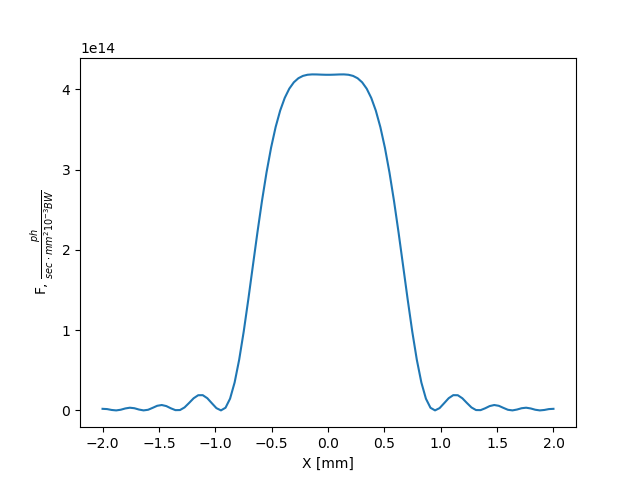

In [17]:
plt.figure(10)
plt.plot(screen.Xph, screen.Total)
plt.ylabel(r"F, $\frac{ph}{sec \cdot mm^2 10^{-3}BW}$")
plt.xlabel(r"X [mm]")
plt.show()

### Plotting utils
you can use standard plotting function 

<IPython.core.display.Javascript object>


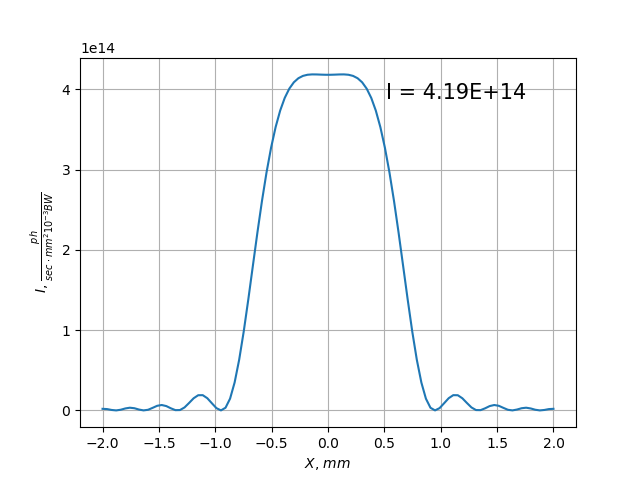

In [21]:
show_flux(screen, unit="mm")

### in [mrad] 

<IPython.core.display.Javascript object>


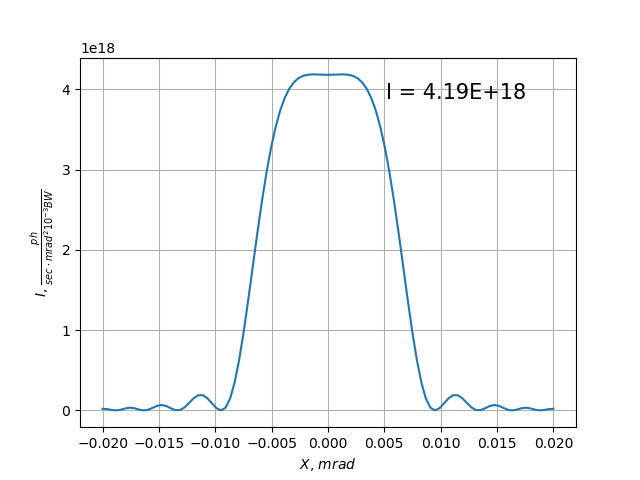

In [20]:
show_flux(screen, unit="mrad",  nfig=2)

<a id='spectrum'></a>
## Specrum 

The same way to calculate spectrum 

<IPython.core.display.Javascript object>


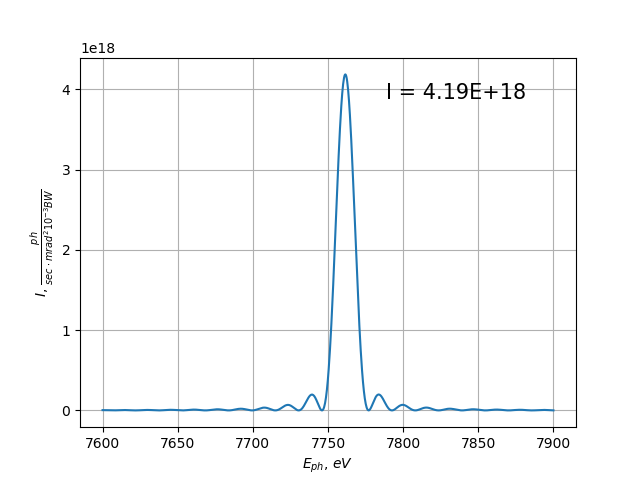

In [23]:
beam = Beam()
beam.E = 2.5            # beam energy in [GeV]
beam.I = 0.1            # beam current in [A]


screen = Screen()
screen.z = 100.0      # distance from the begining of lattice to the screen 


screen.start_energy = 7600 # [eV], starting photon energy
screen.end_energy = 7900     # [eV], ending photon energy
screen.num_energy = 1000        # number of energy points[eV]

screen = calculate_radiation(lat, screen, beam)
show_flux(screen, unit="mrad",  nfig=12)